In [ ]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from utils_segmentation import p3,p4
import hvplot.pandas
np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [ ]:
inputs = ['Rg', 'Tair', 'VPD','elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [ ]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [ ]:
daily_flux_cook=pd.read_csv('Z:/usda/DataLake/work/CookIRCamET/Working/cook_et_batches_processed_all_20250105.csv')
daily_flux_cook['ETMethod'] = 'EC'
daily_flux_cprl=pd.read_csv('Z:/usda/DataLake/work/CookIRCamET/Working/cprl_et_batches_processed_all_20250106.csv')
daily_flux_cprl['ETMethod'] = 'Lysimeter'

In [ ]:
daily_flux_cprl.loc[daily_flux_cprl.times.str[0:4]=='2024','ETMethod'] = 'Water Balance'

In [92]:
daily_flux_cprl['Crop'] = 'Cotton'
daily_flux_cook['Crop'] = 'Canola'
daily_flux_cook.loc[daily_flux_cook.times.str[0:4]!='2024','Crop'] = 'Peas'
daily_flux_cook.loc[daily_flux_cook.times.str[0:4]=='2022','Crop'] = 'Residue'
daily_flux_cook.loc[daily_flux_cook.times.str[5:7]=='01','Crop'] = 'Residue'
daily_flux_cook.loc[daily_flux_cook.times.str[5:7]=='02','Crop'] = 'Residue'
daily_flux_cook.loc[daily_flux_cook.times.str[5:7]=='03','Crop'] = 'Residue'

In [93]:
daily_flux_cook.times.str[5:7]

0       10
1       10
2       10
3       10
4       10
        ..
8755    07
8756    07
8757    07
8758    07
8759    07
Name: times, Length: 8760, dtype: object

In [94]:
lab = 'all'

daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

daily_flux.keys()

daily_flux['DeltaTsshd'] = (daily_flux.Tair-daily_flux.Tsshd)*daily_flux.fsshd
daily_flux['DeltaTssun'] = (daily_flux.Tair-daily_flux.Tssun)*daily_flux.fssun

daily_flux['DeltaTvshd'] = (daily_flux.Tair-daily_flux.Tvshd)*daily_flux.fvshd
daily_flux['DeltaTvsun'] = (daily_flux.Tair-daily_flux.Tvsun)*daily_flux.fvsun

daily_flux['DeltaTrshd'] = (daily_flux.Tair-daily_flux.Trshd)*daily_flux.frshd
daily_flux['DeltaTrsun'] = (daily_flux.Tair-daily_flux.Trsun)*daily_flux.frsun

daily_flux['DeltaTwshd'] = (daily_flux.Tair-daily_flux.Twshd)*daily_flux.fwshd
daily_flux['DeltaTwsun'] = (daily_flux.Tair-daily_flux.Twsun)*daily_flux.fwsun

daily_flux['DeltaVsshd'] = (daily_flux.VPD)*daily_flux.fsshd
daily_flux['DeltaVssun'] = (daily_flux.VPD)*daily_flux.fssun

daily_flux['DeltaVvshd'] = (daily_flux.VPD)*daily_flux.fvshd
daily_flux['DeltaVvsun'] = (daily_flux.VPD)*daily_flux.fvsun

daily_flux['DeltaVrshd'] = (daily_flux.VPD)*daily_flux.frshd
daily_flux['DeltaVrsun'] = (daily_flux.VPD)*daily_flux.frsun

daily_flux['DeltaVwshd'] = (daily_flux.VPD)*daily_flux.fwshd
daily_flux['DeltaVwsun'] = (daily_flux.VPD)*daily_flux.fwsun

daily_flux['Rsshd'] = (daily_flux.Rg)*daily_flux.fsshd
daily_flux['Rssun'] = (daily_flux.Rg)*daily_flux.fssun

daily_flux['Rvshd'] = (daily_flux.Rg)*daily_flux.fvshd
daily_flux['Rvsun'] = (daily_flux.Rg)*daily_flux.fvsun

daily_flux['Rrshd'] = (daily_flux.Rg)*daily_flux.frshd
daily_flux['Rrsun'] = (daily_flux.Rg)*daily_flux.frsun

daily_flux['Rwshd'] = (daily_flux.Rg)*daily_flux.fwshd
daily_flux['Rwsun'] = (daily_flux.Rg)*daily_flux.fwsun

inputs = daily_flux.keys()[-24:]

n_feats = len(inputs)
period_length = 2
batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
n_batches = batched_flux.shape[0]
batches = np.arange(n_batches)


In [95]:
filename = os.path.join(p3,'et_mlp_pipeline_all_2_final.pk.sav')
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb'
    model = pickle.load(f)

In [96]:
X = daily_flux[inputs].values.reshape([-1,2*n_feats])
ET = np.sum(daily_flux['ET'].values.reshape([-1,2]),axis=1)/2
ETMethod = daily_flux.ETMethod[0::2]
Crop = daily_flux.Crop[0::2]

times = pd.to_datetime(daily_flux['times']).values.reshape([-1,2])[:,1]
ET_ = model.predict(X)/2
df = pd.DataFrame({'times':times,'ETobserved':ET,'ETpredicted':ET_,'ETMethod':ETMethod,'Crop':Crop})


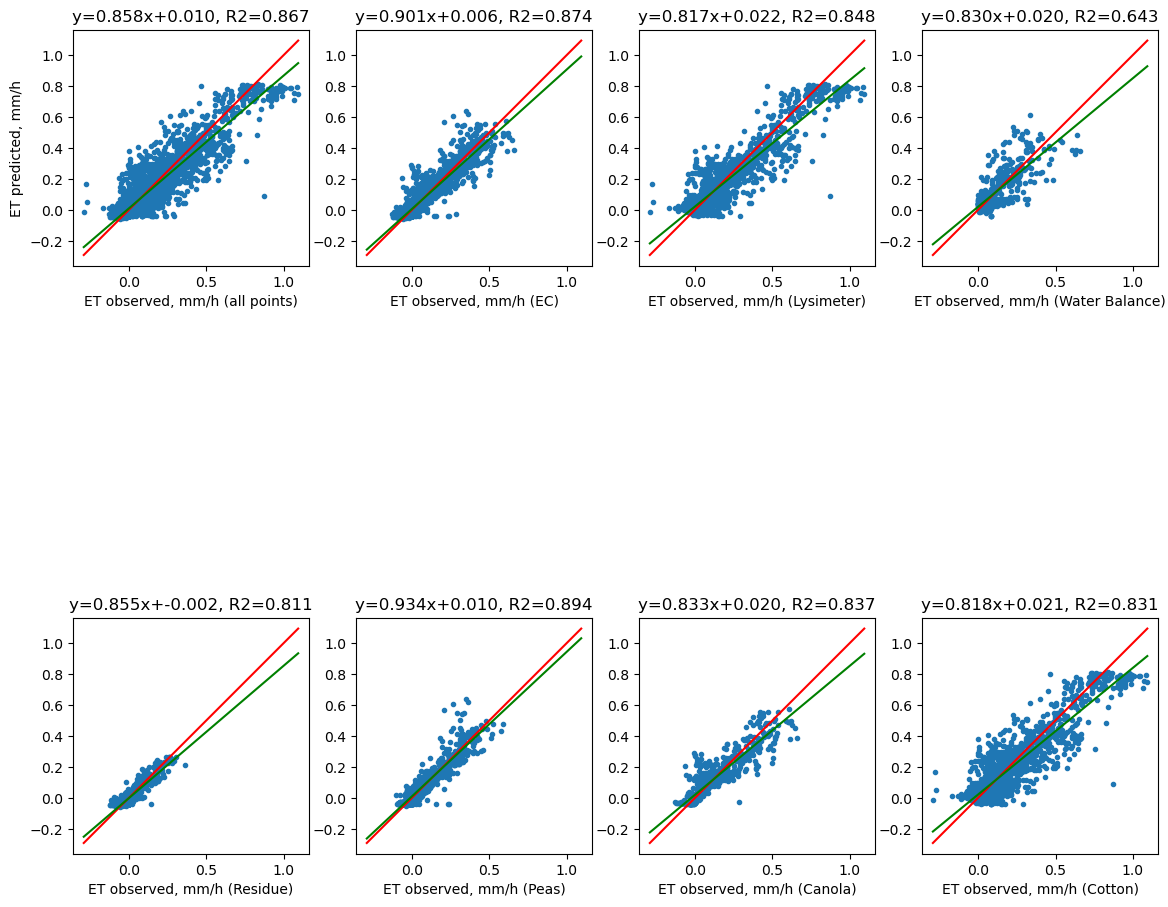

In [97]:
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(14, 14))
axs[0,0].plot(df.ETobserved,df.ETpredicted,'.')
axs[0,0].set_aspect('equal')
plotmin = min([df.ETobserved.min(),df.ETpredicted.min()])
plotmax = max([df.ETobserved.max(),df.ETpredicted.max()])
plotx = np.array([plotmin,plotmax])
axs[0,0].plot(plotx,plotx,'r')
axs[0,0].set_xlabel('ET observed, mm/h (all points)')
axs[0,0].set_ylabel('ET predicted, mm/h')

linmod = LinearRegression()
x = df.ETobserved.values.reshape(-1, 1)
y = df.ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[0,0].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[0,0].set_title(fit)

axs[0,1].plot(df[df.ETMethod=='EC'].ETobserved,df[df.ETMethod=='EC'].ETpredicted,'.')
axs[0,1].set_aspect('equal')
axs[0,1].plot(plotx,plotx,'r')
axs[0,1].set_xlabel('ET observed, mm/h (EC)')

linmod = LinearRegression()
x = df[df.ETMethod=='EC'].ETobserved.values.reshape(-1, 1)
y = df[df.ETMethod=='EC'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[0,1].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[0,1].set_title(fit)

axs[0,2].plot(df[df.ETMethod=='Lysimeter'].ETobserved,df[df.ETMethod=='Lysimeter'].ETpredicted,'.')
axs[0,2].set_aspect('equal')
axs[0,2].plot(plotx,plotx,'r')
axs[0,2].set_xlabel('ET observed, mm/h (Lysimeter)')

linmod = LinearRegression()
x = df[df.ETMethod=='Lysimeter'].ETobserved.values.reshape(-1, 1)
y = df[df.ETMethod=='Lysimeter'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[0,2].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[0,2].set_title(fit)

axs[0,3].plot(df[df.ETMethod=='Water Balance'].ETobserved,df[df.ETMethod=='Water Balance'].ETpredicted,'.')
axs[0,3].set_aspect('equal')
axs[0,3].plot(plotx,plotx,'r')
axs[0,3].set_xlabel('ET observed, mm/h (Water Balance)')

linmod = LinearRegression()
x = df[df.ETMethod=='Water Balance'].ETobserved.values.reshape(-1, 1)
y = df[df.ETMethod=='Water Balance'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[0,3].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[0,3].set_title(fit)


axs[1,0].plot(df[df.Crop=='Residue'].ETobserved,df[df.Crop=='Residue'].ETpredicted,'.')
axs[1,0].set_aspect('equal')
axs[1,0].plot(plotx,plotx,'r')
axs[1,0].set_xlabel('ET observed, mm/h (Residue)')

linmod = LinearRegression()
x = df[df.Crop=='Residue'].ETobserved.values.reshape(-1, 1)
y = df[df.Crop=='Residue'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[1,0].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[1,0].set_title(fit)

axs[1,1].plot(df[df.Crop=='Peas'].ETobserved,df[df.Crop=='Peas'].ETpredicted,'.')
axs[1,1].set_aspect('equal')
axs[1,1].plot(plotx,plotx,'r')
axs[1,1].set_xlabel('ET observed, mm/h (Peas)')

linmod = LinearRegression()
x = df[df.Crop=='Peas'].ETobserved.values.reshape(-1, 1)
y = df[df.Crop=='Peas'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[1,1].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[1,1].set_title(fit)

axs[1,2].plot(df[df.Crop=='Canola'].ETobserved,df[df.Crop=='Canola'].ETpredicted,'.')
axs[1,2].set_aspect('equal')
axs[1,2].plot(plotx,plotx,'r')
axs[1,2].set_xlabel('ET observed, mm/h (Canola)')

linmod = LinearRegression()
x = df[df.Crop=='Canola'].ETobserved.values.reshape(-1, 1)
y = df[df.Crop=='Canola'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[1,2].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[1,2].set_title(fit)

axs[1,3].plot(df[df.Crop=='Cotton'].ETobserved,df[df.Crop=='Cotton'].ETpredicted,'.')
axs[1,3].set_aspect('equal')
axs[1,3].plot(plotx,plotx,'r')
axs[1,3].set_xlabel('ET observed, mm/h (Cotton)')

linmod = LinearRegression()
x = df[df.Crop=='Cotton'].ETobserved.values.reshape(-1, 1)
y = df[df.Crop=='Cotton'].ETpredicted.values.reshape(-1, 1)
linmod.fit(x,y)
x_ = plotx.reshape(-1, 1)
y_ = linmod.predict(x_)
axs[1,3].plot(x_,y_,'g')
fit ='y=%1.3fx+%1.3f, R2=%1.3f'%(linmod.coef_[0][0],linmod.intercept_[0],linmod.score(x,y))
axs[1,3].set_title(fit)


filename = 'G:/Shared drives/CookIRCamET/Documents/AsabeAppliedEngineering25/et_comparison_'+datestr+'.png'
fig.savefig(filename,dpi=300)

In [ ]:
linmod.score(x,y)